# Use lexicon-based sentiment to classify documents
In this example, we try to classify documents by exploiting lexicon-based sentiment scores combined with tfidf in order to vectorize documents.

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

## Collect some data

In [2]:
import json

In [3]:
review_data_file = '../lexicon/data/yelp_sample.json'
with open(review_data_file, 'r') as infile:
    R = json.load(infile)

In [4]:
len(R)

10000

In [5]:
R[0]

{'content': "Red, white and bleu salad was super yum and a great addition to the menu! This location was clean with great service and food served at just the right temps! Kids pizza is always a hit too with lots of great side dish options for the kiddos! When I'm on this side of town, this will definitely be a spot I'll hit up again!",
 'date': '2014-02-17',
 'stars': 4,
 'useful': 1,
 'funny': 0,
 'cool': 0,
 'business': 'Ue6-WhXvI-_1xUIuapl0zQ',
 'id': '----X0BIDP9tA49U3RvdSQ',
 'categories': ['American (Traditional)', 'Burgers', 'Restaurants']}

## Task: guess the number of stars for each review

In [6]:
target_values = set([doc['stars'] for doc in R])
target_values

{1, 2, 3, 4, 5}

## TfIdf Indexing

In [7]:
from nltk.tokenize import word_tokenize
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

### Reduce number of documents and number of features

In [8]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [9]:
R = R[:4000]
lemmatized_docs = [] 
for text in tqdm(R):
    content = nlp(text['content'])
    tokens = []
    for sent in content.sents:
        for token in sent:
            if token.pos_ in {'ADJ', 'ADV', 'NOUN', 'VERB', 'PNOUN'}:
                tokens.append(token.lemma_.lower())
    lemmatized_docs.append(" ".join(tokens))

  0%|          | 0/4000 [00:00<?, ?it/s]

In [11]:
lemmatized_docs[0]

'red white salad super yum great addition menu location clean great service food serve just right temp kid pizza always hit too lot great side dish option kiddo side town definitely spot hit again'

In [12]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split())
X = vectorizer.fit_transform(lemmatized_docs).toarray() # dense to sparse
y = [x['stars'] for x in R]

In [13]:
features = vectorizer.get_feature_names_out()

In [15]:
features[:10]

array(['!', '"ignore', '#', '$', '%', "'", '(:', '(=', "(c'mon", '(eye'],
      dtype=object)

In [16]:
X.shape

(4000, 11345)

## Sentiment polarity

### SentiWordnet
In this example we just get the mean of polarities for all the synsets associated with a word.

In [17]:
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn

In [18]:
def sentiwn_score(word):
    synsets = list(swn.senti_synsets(word))
    score = 0.0
    if len(synsets) > 0:
        polarity = pd.DataFrame([{'pos': sw.pos_score(), 
                                  'neg': sw.neg_score(), 
                                  'obj': sw.obj_score()} for sw in synsets])
        avg_polarity = polarity.mean()
        score = (avg_polarity['pos'] + avg_polarity['obj']) - (avg_polarity['neg'] + avg_polarity['obj'])
    return score

In [22]:
sentiwn_score('best')

0.4845116279069768

In [23]:
scores = []
for word in tqdm(features):
    scores.append(sentiwn_score(word))
scores = np.array(scores)

  0%|          | 0/11345 [00:00<?, ?it/s]

### Combine scores with TfIdf

In [24]:
Xsw = X * scores

In [29]:
bag_of_words = {}
for i, score in enumerate(Xsw[0]):
    if score > 0:
        bag_of_words[features[i]] = score
bow = pd.Series(bag_of_words)

In [30]:
bow.sort_values(ascending=False)

great         0.060826
definitely    0.029486
just          0.028308
right         0.022378
clean         0.016761
dish          0.013697
super         0.011188
white         0.003854
serve         0.002273
dtype: float64

In [31]:
bag_of_words = {}
for i, score in enumerate(X[0]):
    if score > 0:
        bag_of_words[features[i]] = score
bow2 = pd.Series(bag_of_words)

In [32]:
bow2.sort_values(ascending=False)

hit           0.366694
kiddo         0.300288
temp          0.279038
side          0.277652
yum           0.273967
great         0.243304
addition      0.200076
white         0.192703
red           0.187010
town          0.166945
kid           0.163429
pizza         0.155529
spot          0.152120
option        0.150616
super         0.149169
dish          0.146102
salad         0.145776
serve         0.145453
clean         0.138557
location      0.137498
right         0.128895
lot           0.128071
menu          0.126869
again         0.119294
definitely    0.117944
always        0.116044
too           0.113394
just          0.090586
service       0.085581
food          0.078780
dtype: float64

### Vader
See [https://github.com/cjhutto/vaderSentiment](https://github.com/cjhutto/vaderSentiment).

Vader can be used either for scoring single words, or for getting a comprehensive score for the whole text document (i.e., `compound score`). In the folowing we see and example of sentence score evaluation.

In [67]:
from nltk.tokenize import sent_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [68]:
analyzer = SentimentIntensityAnalyzer()
doc = R[0]['content']
for sent in sent_tokenize(doc):
    vs = analyzer.polarity_scores(sent)
    print(sent)
    print(vs)
    print('===============')

Red, white and bleu salad was super yum and a great addition to the menu!
{'neg': 0.0, 'neu': 0.611, 'pos': 0.389, 'compound': 0.8516}
This location was clean with great service and food served at just the right temps!
{'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'compound': 0.7959}
Kids pizza is always a hit too with lots of great side dish options for the kiddos!
{'neg': 0.0, 'neu': 0.785, 'pos': 0.215, 'compound': 0.6588}
When I'm on this side of town, this will definitely be a spot I'll hit up again!
{'neg': 0.0, 'neu': 0.842, 'pos': 0.158, 'compound': 0.4574}


### TextBlob
See [https://textblob.readthedocs.io/en/dev/](https://textblob.readthedocs.io/en/dev/).

TextBlob is a NLP library that provides also some polarity facilities. Let's see an example.

In [69]:
from textblob import TextBlob

In [70]:
blob = TextBlob(R[0]['content'])
print(blob.tags)
print(blob.noun_phrases)

[('Red', 'NNP'), ('white', 'JJ'), ('and', 'CC'), ('bleu', 'JJ'), ('salad', 'NN'), ('was', 'VBD'), ('super', 'JJ'), ('yum', 'NN'), ('and', 'CC'), ('a', 'DT'), ('great', 'JJ'), ('addition', 'NN'), ('to', 'TO'), ('the', 'DT'), ('menu', 'NN'), ('This', 'DT'), ('location', 'NN'), ('was', 'VBD'), ('clean', 'JJ'), ('with', 'IN'), ('great', 'JJ'), ('service', 'NN'), ('and', 'CC'), ('food', 'NN'), ('served', 'VBD'), ('at', 'IN'), ('just', 'RB'), ('the', 'DT'), ('right', 'JJ'), ('temps', 'NN'), ('Kids', 'NNP'), ('pizza', 'NN'), ('is', 'VBZ'), ('always', 'RB'), ('a', 'DT'), ('hit', 'NN'), ('too', 'RB'), ('with', 'IN'), ('lots', 'NNS'), ('of', 'IN'), ('great', 'JJ'), ('side', 'JJ'), ('dish', 'NN'), ('options', 'NNS'), ('for', 'IN'), ('the', 'DT'), ('kiddos', 'NN'), ('When', 'WRB'), ('I', 'PRP'), ("'m", 'VBP'), ('on', 'IN'), ('this', 'DT'), ('side', 'NN'), ('of', 'IN'), ('town', 'NN'), ('this', 'DT'), ('will', 'MD'), ('definitely', 'RB'), ('be', 'VB'), ('a', 'DT'), ('spot', 'NN'), ('I', 'PRP'), ("'

In [71]:
for sent in blob.sentences:
    print(sent)
    print(sent.sentiment)
    print('===============')

Red, white and bleu salad was super yum and a great addition to the menu!
Sentiment(polarity=0.3333333333333333, subjectivity=0.35416666666666663)
This location was clean with great service and food served at just the right temps!
Sentiment(polarity=0.5079365079365079, subjectivity=0.6619047619047619)
Kids pizza is always a hit too with lots of great side dish options for the kiddos!
Sentiment(polarity=1.0, subjectivity=0.75)
When I'm on this side of town, this will definitely be a spot I'll hit up again!
Sentiment(polarity=0.0, subjectivity=0.5)


## Supervised classification (with SentiWn)

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [34]:
X_train, X_test, y_train, y_test = train_test_split(Xsw, y, random_state=42)

In [35]:
scls = RandomForestClassifier()
scls.fit(X_train, y_train)

RandomForestClassifier()

In [36]:
y_pred = scls.predict(X_test)

In [37]:
y_pred[:10]

array([5, 5, 1, 4, 5, 1, 5, 5, 5, 1])

In [38]:
P = scls.predict_proba(X_test)
P.shape

(1000, 5)

In [39]:
np.round(P[0], 3)

array([0.05, 0.01, 0.11, 0.35, 0.48])

In [40]:
P.mean(axis=0)

array([0.14989, 0.06541, 0.09891, 0.23613, 0.44966])

### Evaluation

In [41]:
import matplotlib.pyplot as plt

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [43]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       0.55      0.47      0.51       146
           2       0.00      0.00      0.00        71
           3       0.67      0.03      0.07       116
           4       0.37      0.17      0.23       234
           5       0.54      0.94      0.68       433

    accuracy                           0.52      1000
   macro avg       0.42      0.32      0.30      1000
weighted avg       0.48      0.52      0.43      1000



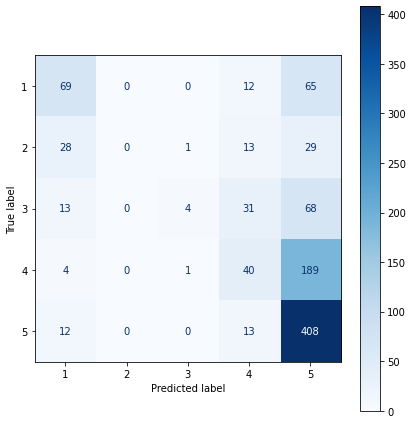

In [44]:
cm = confusion_matrix(y_test, y_pred, labels=list(range(1, 6)))
display = ConfusionMatrixDisplay(cm, display_labels=list(range(1, 6)))
fig, ax = plt.subplots(figsize=(6,6))
display.plot(ax=ax, cmap='Blues')
plt.tight_layout()
plt.show()

## Look at the features

In [55]:
weights = Xsw.mean(axis=0)

In [63]:
class_1_idx = [i for i, x in enumerate(y_pred) if x == 5]
class_1_w = Xsw[class_1_idx].mean(axis=0)

In [64]:
diff = class_1_w - weights

In [65]:
d = [(features[i], x) for i, x in sorted(enumerate(diff), key=lambda z: -z[1])]

In [66]:
for feature, relevance in d[:10]:
    print(feature, relevance)

nice 0.001429051367384613
absolutely 0.0012205905181049926
bad 0.0012012116014919819
delicious 0.0007974326999322648
highly 0.000658662657833466
mom 0.0006187328980650753
unprofessional 0.0005487786519260576
beware 0.0004949424555200536
room 0.00047185353491554854
totally 0.00044762765884348034
